<a href="https://colab.research.google.com/github/ivangrbnv/STAT5243_proj1/blob/main/5243_proj1_ig2447.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q anndata
!pip install -q scanpy
!pip install -q 'scanpy[leiden]'
!pip install -q 'scanpy[louvain]'
!pip install -q numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import scanpy as sc
extract_dir = "/content/drive/MyDrive/5243_proj1/Frogtail_files" # use your own directory
adata = sc.read_h5ad(extract_dir+'/cleaned_processed_frogtail.h5ad') # file path

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
adata.obs.head()

barcode_cells                cell  sample DevelopmentalStage  \
0  AAACCTGAGCTAGTTC.1  AAACCTGAGCTAGTTC.1  SIGAB5               st40   
1  AAACCTGGTGGGTCAA.1  AAACCTGGTGGGTCAA.1  SIGAB5               st40   
2  AAACCTGGTTTGTTGG.1  AAACCTGGTTTGTTGG.1  SIGAB5               st40   
3  AAACGGGGTCGGCATC.1  AAACGGGGTCGGCATC.1  SIGAB5               st40   
4  AAACGGGTCCTACAGA.1  AAACGGGTCCTACAGA.1  SIGAB5               st40   

   DaysPostAmputation        cluster         X          Y CellCyclePhase  \
0                   3  Erythrocyte 4 -6.395430   0.832323            G2M   
1                   3      Myeloid 1 -2.428271  13.826715             G1   
2                   3  Beta ionocyte -1.398049 -14.653897             G1   
3                   3  Erythrocyte 4 -5.863765   0.489598            G2M   
4                   3    Goblet cell  2.106444  -6.594430             G1   

   Sample       Lane Condition  batch  
0  SIGAB5  SLX-15583    ST40_3      3  
1  SIGAB5  SLX-15583    ST40_3      3  
2  SIGAB5  SLX-15583    ST40_3      3  
3  SIGAB5  SLX-15583    ST40_3      3  
4  SIGAB5  SLX-15583    ST40_3      3

In [6]:
adata.X

<13199x31535 sparse matrix of type '<class 'numpy.int64'>'
	with 29297098 stored elements in Compressed Sparse Row format>

In [7]:
adata.X.toarray()[:5, :20]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<Axes: xlabel='DaysPostAmputation', ylabel='Count'>

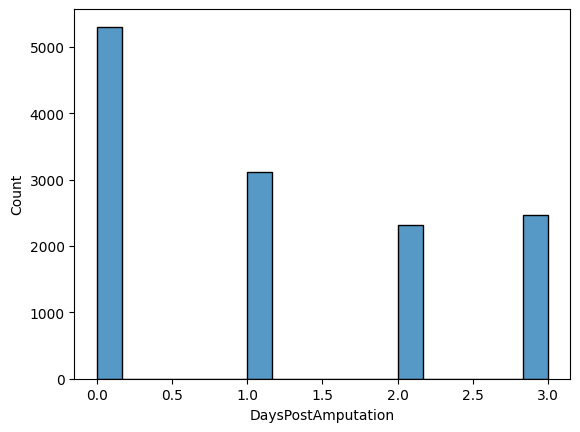

In [8]:
import seaborn as sns
sns.histplot(adata.obs['DaysPostAmputation'])

In [9]:
adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer

In [10]:
#Load the given gene list use own directory
given_genes = pd.read_csv('/content/drive/MyDrive/5243_proj1/ROC_genes.csv', header=None)
given_genes_list = given_genes[0].tolist()

given_genes_set = set(given_genes_list)

In [11]:
sc.pp.normalize_total(adata)
#Logarithmize the data
sc.pp.log1p(adata)

In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes=4500, min_disp=1.0)

#subsetting adata to only HVGs
hvg_adata = adata[:, adata.var['highly_variable']].copy()

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


In [13]:
#Remove the .L, .S, and .g suffixes from the gene names in adata
genes_in_data_cleaned = [gene.replace('.L', '').replace('.S', '').replace('.g', '') for gene in hvg_adata.var_names]

genes_in_data_set = set(genes_in_data_cleaned)


given_genes_cleaned = given_genes_list

#Check which genes from your list are present in the cleaned hvg_adata genes
present_genes = [gene for gene in given_genes_cleaned if gene in genes_in_data_set]
missing_genes = [gene for gene in given_genes_cleaned if gene not in genes_in_data_set]

print(f"Genes present in the dataset: {present_genes}")
print(f"Genes missing from the dataset: {missing_genes}")

Genes present in the dataset: ['wnt5a', 'loc100488523', 'loc100492954', 'egfl6', 'lpar3', 'cpa6', 'sp9', 'fgf9', 'fbn2', 'tinagl1', 'fgf7', 'vwde', 'lef1', 'lamb2', 'fgfr4', 'fgf7', 'rspo2', 'cpa6', 'loc100498358', 'krt', 'loc100486832', 'jag1', 'Xelaev18043128m', 'dlx2', 'tp73', 'gdf6', 'Xelaev18046800m', 'nid2', 'igfbp2', 'ism2', 'dlx2', 'loc100493805', 'frem2', 'Xelaev18044182m', 'bmp5', 'tspear', 'sema3f', 'robo4', 'jchain', 'rspo2', 'adamts18', 'pltp', 'Xelaev18034799m', 'lamb1', 'lamb1', 'unc5b', 'mmp28', 'pzp', 'galnt15']
Genes missing from the dataset: ['fgf10']


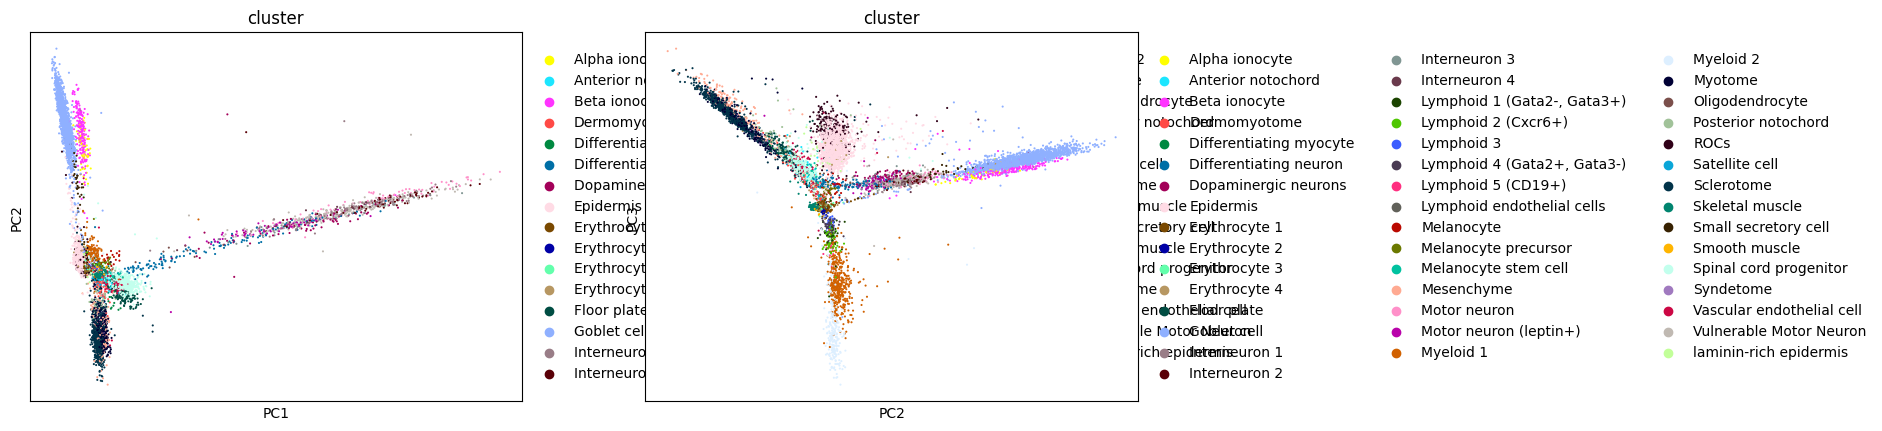

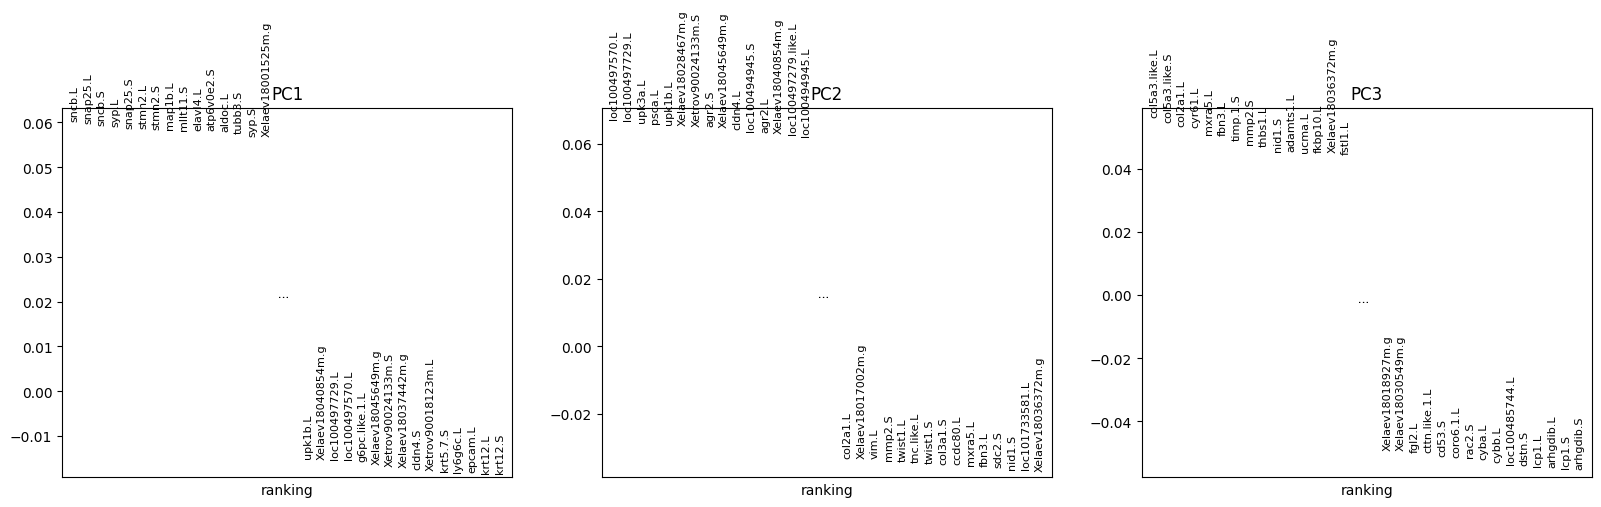

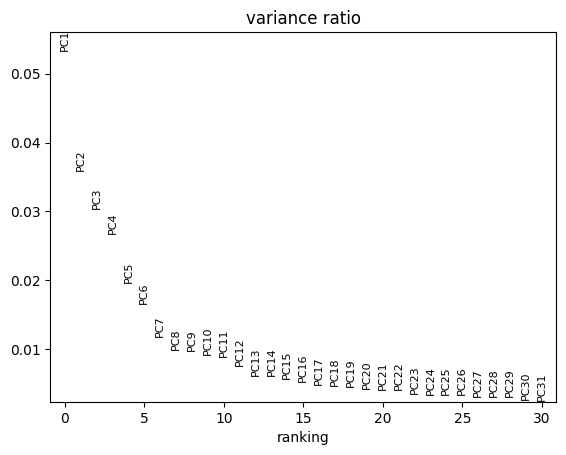

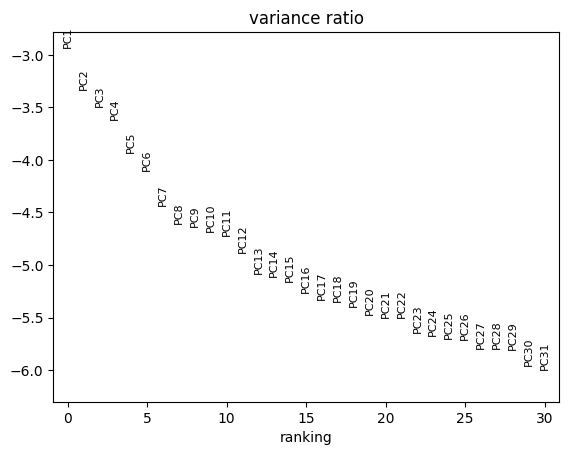

In [14]:
#Scale data
sc.pp.scale(hvg_adata)

#PCA, highly variable genes data
sc.tl.pca(hvg_adata)

#Plot PCA
sc.pl.pca_overview(hvg_adata, color='cluster', components=['1,2', '2,3'])

#Plot variance ratio of PCs
sc.pl.pca_variance_ratio(hvg_adata, log=True)

In [15]:
# Whitening step - create neighbors graph based on PCA
sc.pp.neighbors(hvg_adata, n_pcs=7) # Create neighbors graph - n_pcs takes the number of principal components from PCA you keep for this step
sc.tl.leiden(hvg_adata, resolution=3.0)  # Apply Leiden clustering


<ipython-input-15-4c7d536a8175>:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(hvg_adata, resolution=3.0)  # Apply Leiden clustering


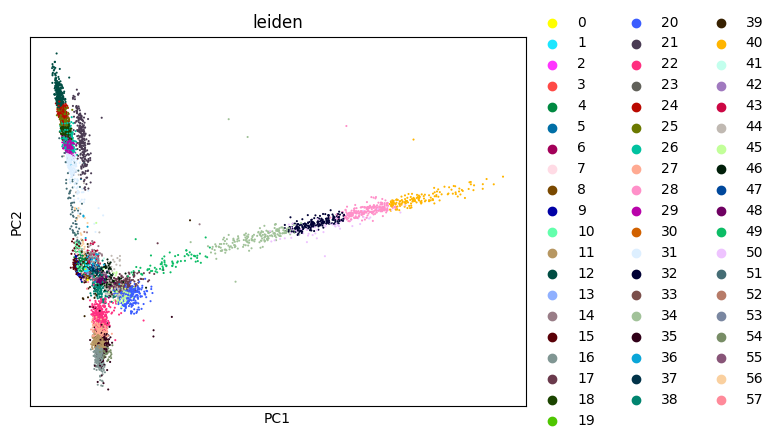

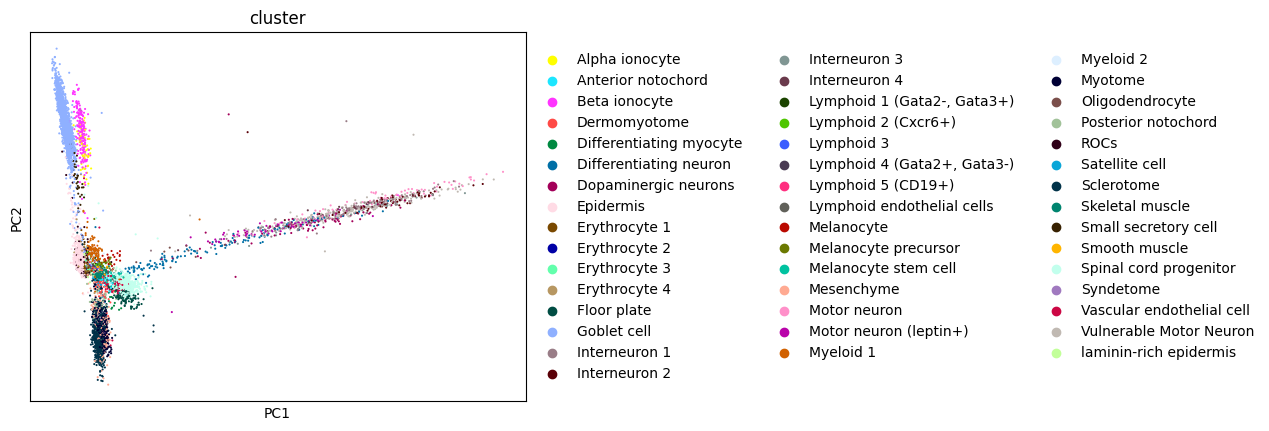

In [16]:
sc.pl.pca(hvg_adata, color=['leiden']) # Plotting PC1/PC2 with colors from Leiden labels
sc.pl.pca(hvg_adata, color=['cluster']) # Plotting PC1/PC2 with colors from original paper cluster

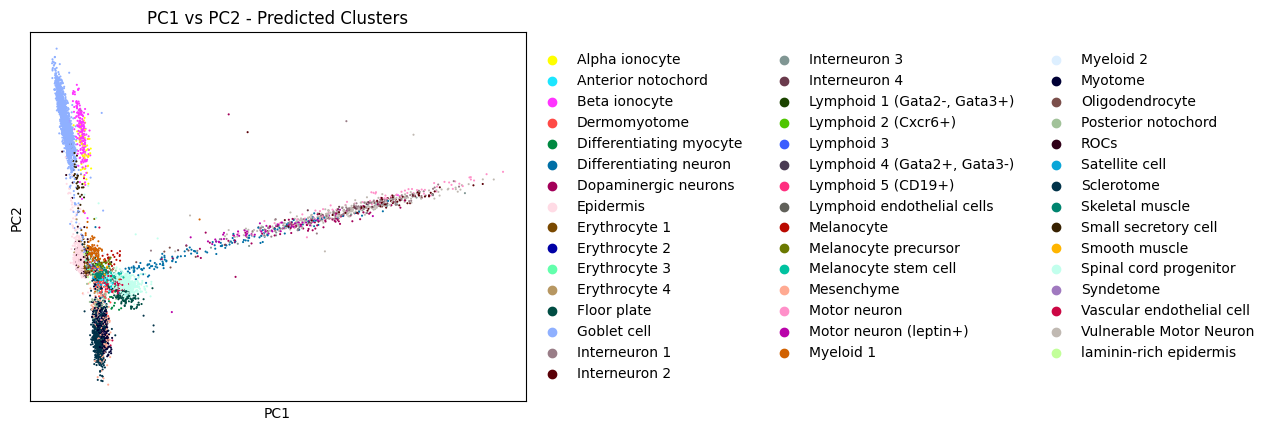

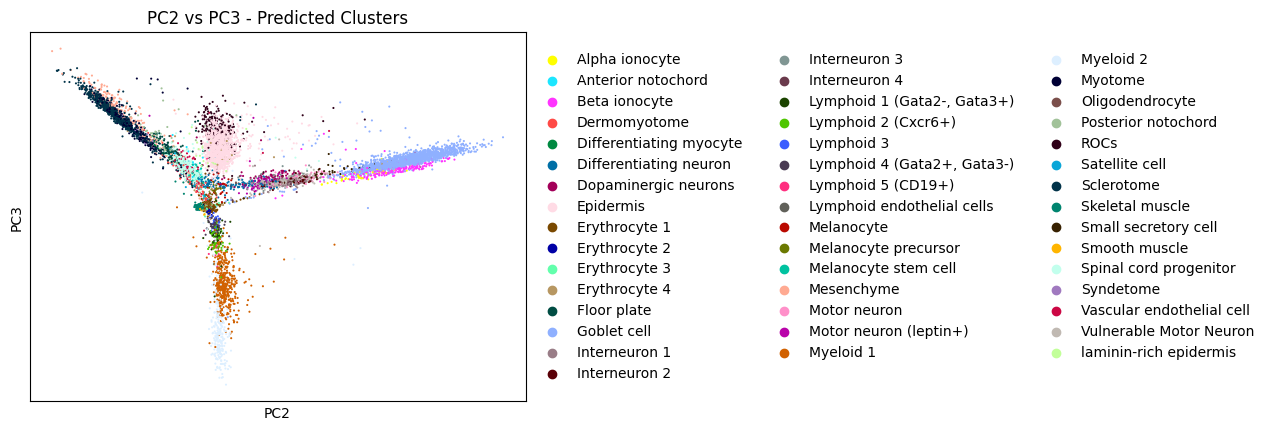

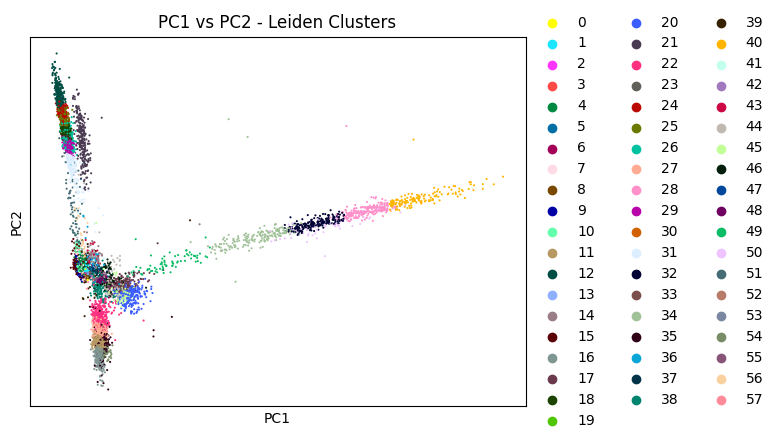

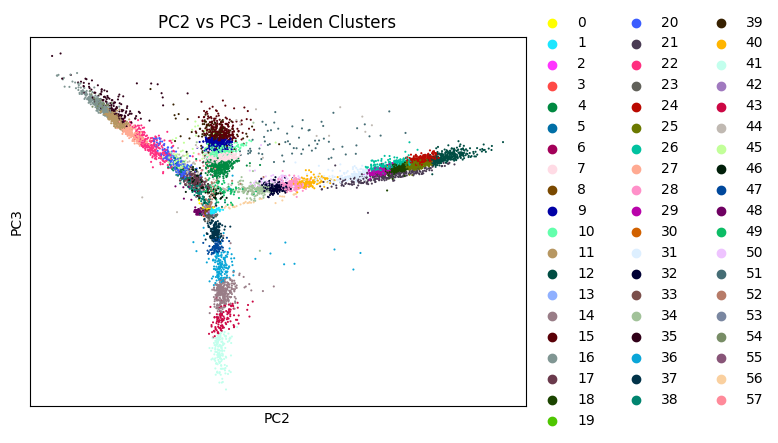

In [17]:
#PC1 vs PC2
sc.pl.pca(hvg_adata, color='cluster', components=['1,2'], title='PC1 vs PC2 - Predicted Clusters')

#PC2 vs PC3
sc.pl.pca(hvg_adata, color='cluster', components=['2,3'], title='PC2 vs PC3 - Predicted Clusters')

#PC1 vs PC2, Leiden
sc.pl.pca(hvg_adata, color='leiden', components=['1,2'], title='PC1 vs PC2 - Leiden Clusters')

#PC2 vs PC3, Leiden
sc.pl.pca(hvg_adata, color='leiden', components=['2,3'], title='PC2 vs PC3 - Leiden Clusters')


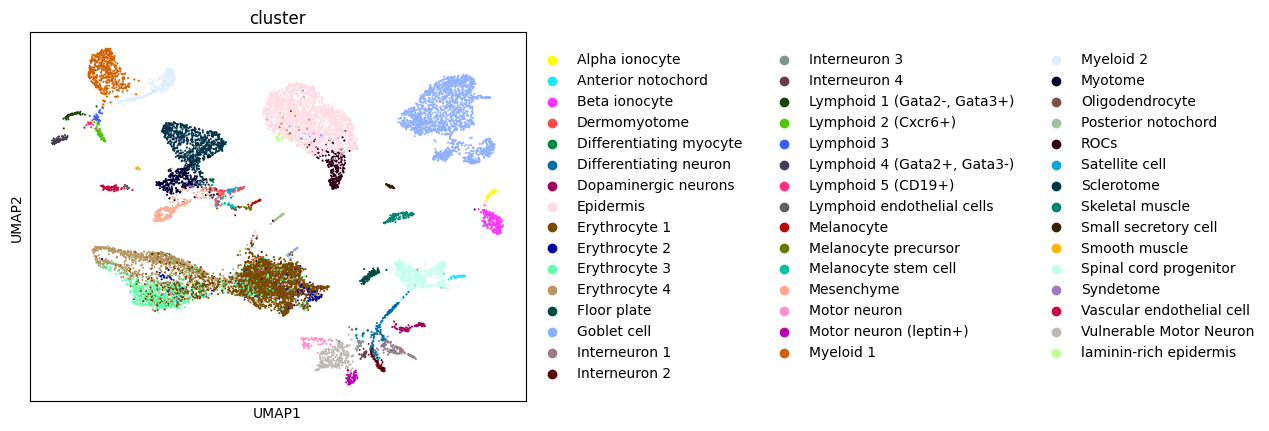

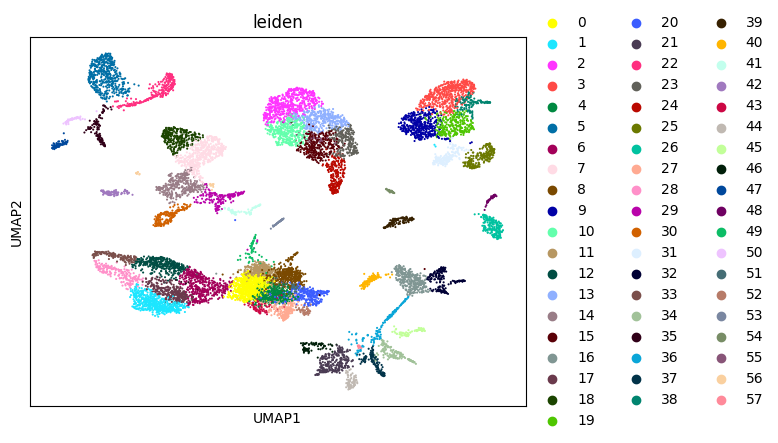

In [18]:
sc.pp.neighbors(hvg_adata, n_neighbors=35, use_rep='X_pca')

#UMAP
sc.tl.umap(hvg_adata)

#clustering using the Leiden algorithm
sc.tl.leiden(hvg_adata, resolution=3.0)

#Plot UMAP colored by clusters and 'leiden' clusters
sc.pl.umap(hvg_adata, color=['cluster'])
sc.pl.umap(hvg_adata, color=['leiden'])

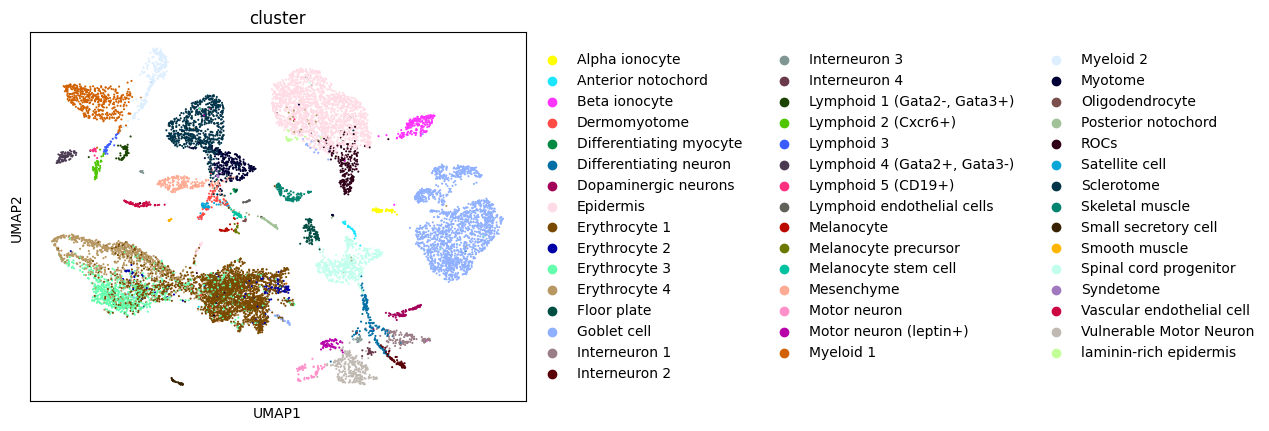

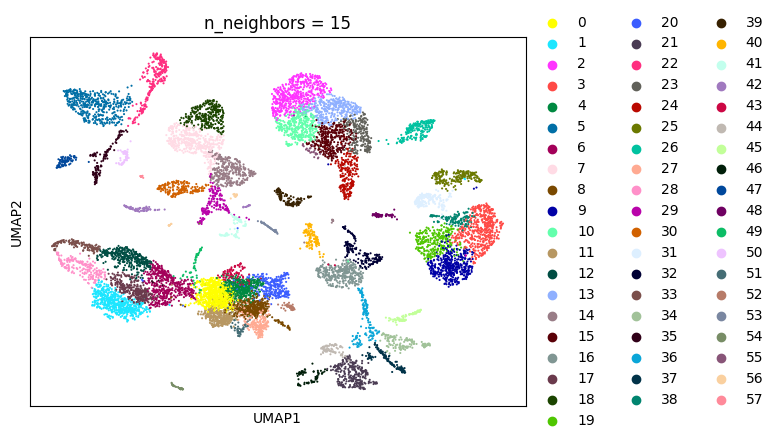

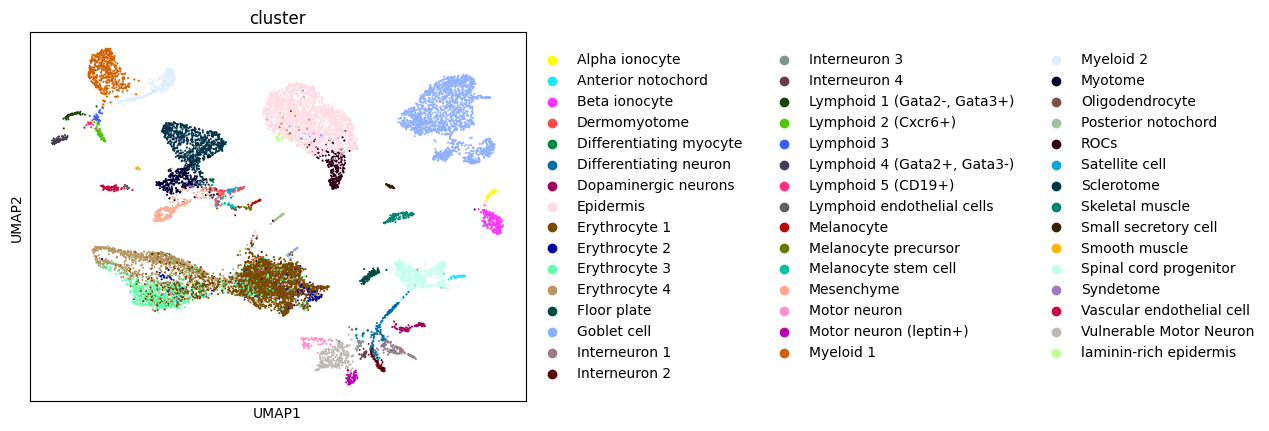

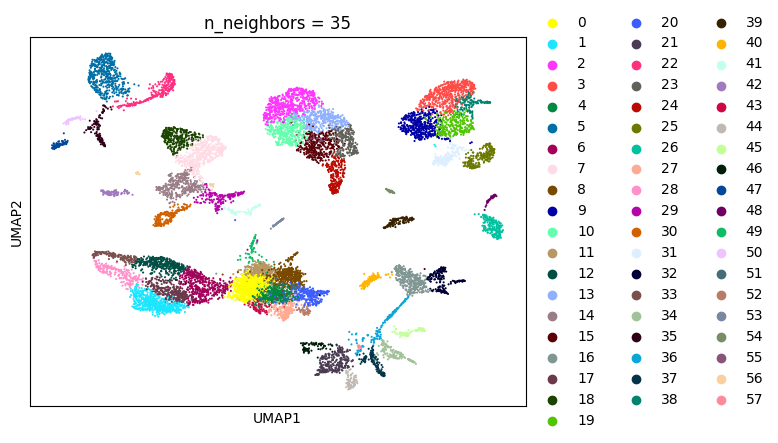

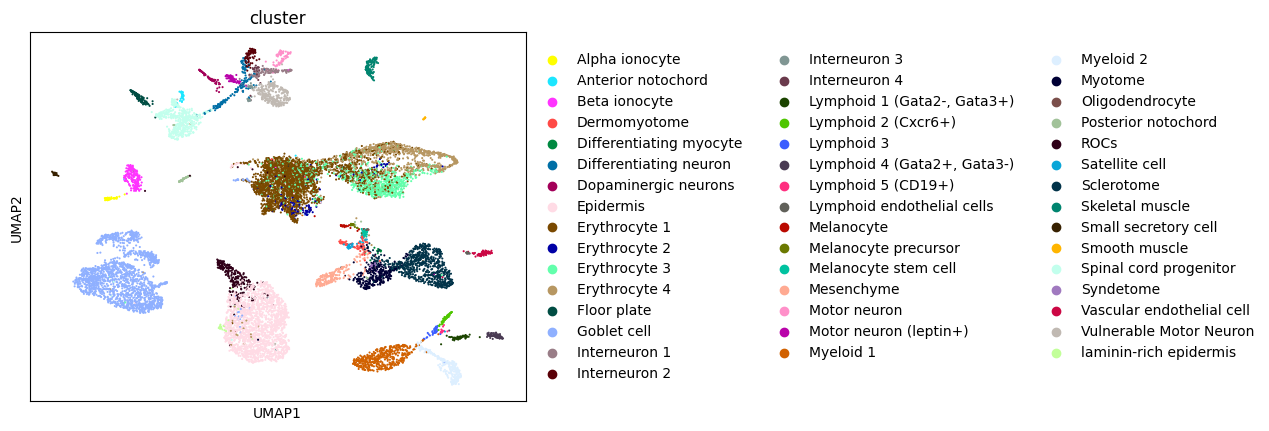

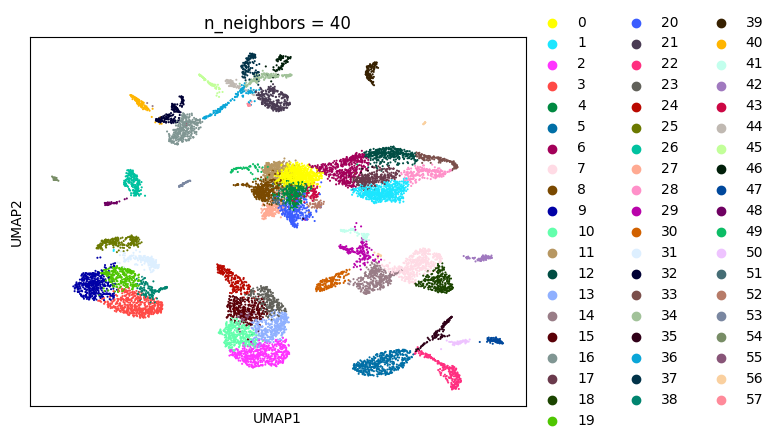

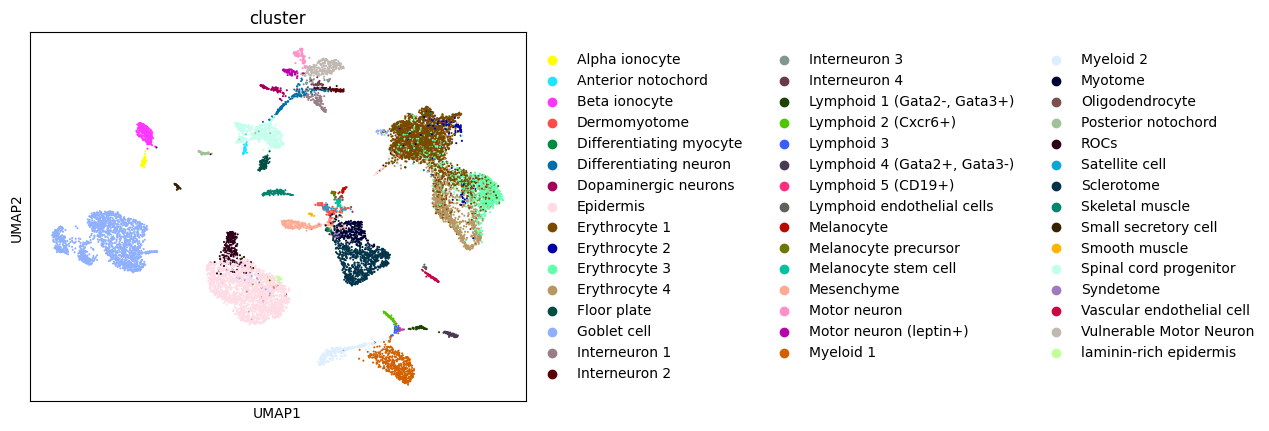

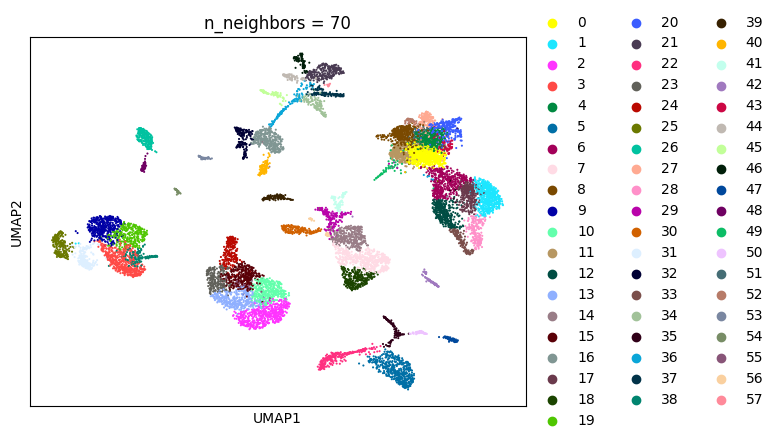

In [19]:
#different n_neighbors values
sc.tl.leiden(hvg_adata, resolution=3.0)
for n in [15, 35, 40, 70]:
    sc.pp.neighbors(hvg_adata, n_neighbors=n, use_rep='X_pca')
    sc.tl.umap(hvg_adata)

    #Plot UMAPs
    sc.pl.umap(hvg_adata, color=['cluster'])
    sc.pl.umap(hvg_adata, color=['leiden'],title=f'n_neighbors = {n}')


In [20]:
#Metrics
cluster_labels_dict = {}

for n in [15, 35, 40, 70]:
    #Compute neighbors graph with different n_neighbors values
    sc.pp.neighbors(hvg_adata, n_neighbors=n, use_rep='X_pca')

    #Apply Leiden clustering
    sc.tl.leiden(hvg_adata, resolution=3.0)

    #Extract Leiden cluster labels for this n_neighbors value
    leiden_labels = hvg_adata.obs['leiden'].astype(int).values

    #Compute Silhouette Score based on PCA
    X_pca = hvg_adata.obsm['X_pca']
    silhouette_avg = silhouette_score(X_pca, leiden_labels)

    cluster_labels_dict[n] = leiden_labels

    #calculate ARI if you want to compare with Louvain or another clustering
    sc.tl.louvain(hvg_adata, resolution=3.0)
    louvain_labels = hvg_adata.obs['louvain'].astype(int).values
    ari_louvain_vs_leiden = adjusted_rand_score(louvain_labels, leiden_labels)

    print(f'n_neighbors = {n}: Silhouette Score = {silhouette_avg}, ARI (vs Louvain) = {ari_louvain_vs_leiden}')

#compare ARI and Rand Index between different n_neighbors values
n_neighbors_values = [15, 35, 40, 70]

print("\nARI and Rand Index comparisons between different n_neighbors values:")
for i, n1 in enumerate(n_neighbors_values):
    for n2 in n_neighbors_values[i+1:]:
        #Compare clustering results between two different n_neighbors values using Rand Index
        rand_idx = rand_score(cluster_labels_dict[n1], cluster_labels_dict[n2])

        #Compute ARI between different n_neighbors clustering results
        ari_between_neighbors = adjusted_rand_score(cluster_labels_dict[n1], cluster_labels_dict[n2])

        print(f'Rand Index between n_neighbors = {n1} and n_neighbors = {n2}: {rand_idx}')
        print(f'ARI between n_neighbors = {n1} and n_neighbors = {n2}: {ari_between_neighbors}')


n_neighbors = 15: Silhouette Score = 0.1858852505683899, ARI (vs Louvain) = 0.6691230335959867
n_neighbors = 35: Silhouette Score = 0.18005803227424622, ARI (vs Louvain) = 0.722341916490299
n_neighbors = 40: Silhouette Score = 0.18622244894504547, ARI (vs Louvain) = 0.755020359760672
n_neighbors = 70: Silhouette Score = 0.17563335597515106, ARI (vs Louvain) = 0.6849367039953

ARI and Rand Index comparisons between different n_neighbors values:
Rand Index between n_neighbors = 15 and n_neighbors = 35: 0.9924106145288919
ARI between n_neighbors = 15 and n_neighbors = 35: 0.845217350417086
Rand Index between n_neighbors = 15 and n_neighbors = 40: 0.9930470309706863
ARI between n_neighbors = 15 and n_neighbors = 40: 0.8582273455319462
Rand Index between n_neighbors = 15 and n_neighbors = 70: 0.9894684858419558
ARI between n_neighbors = 15 and n_neighbors = 70: 0.793865649854589
Rand Index between n_neighbors = 35 and n_neighbors = 40: 0.9963802150123626
ARI between n_neighbors = 35 and n_n

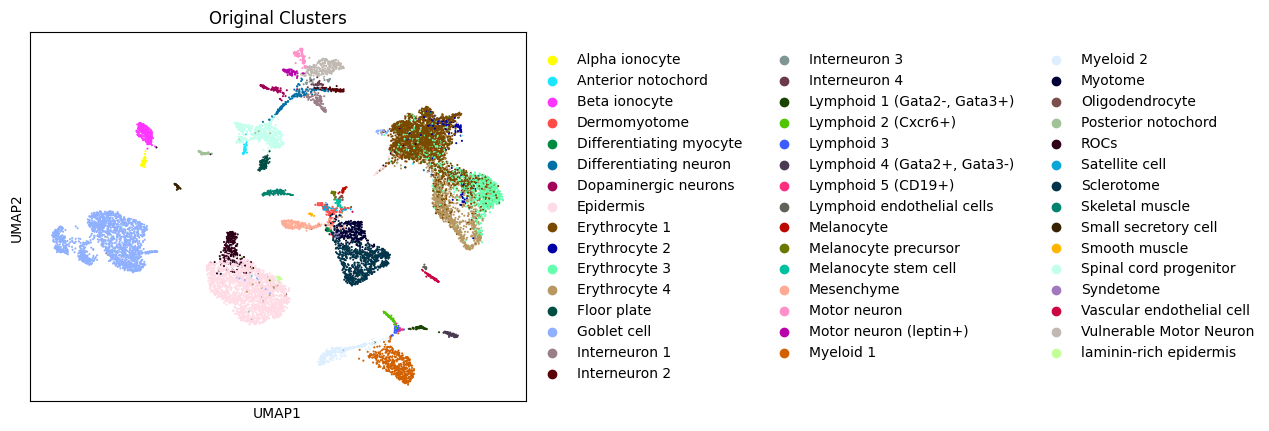

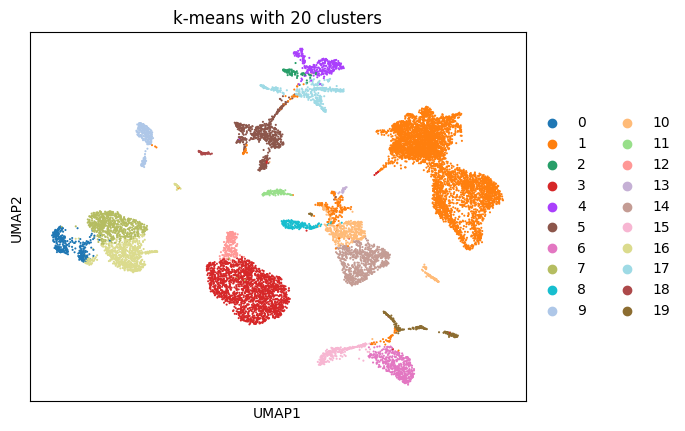

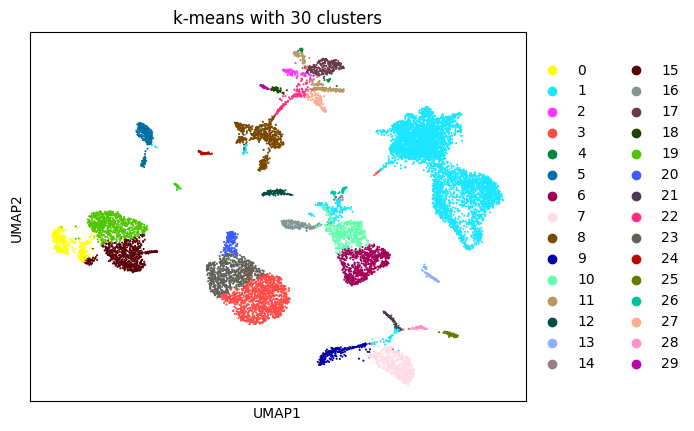

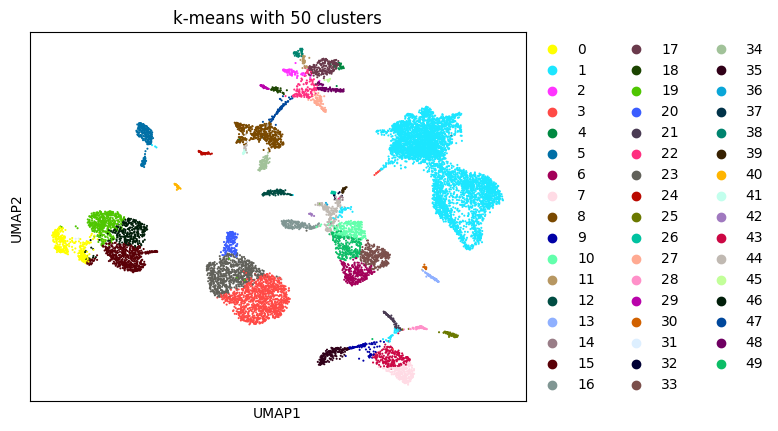

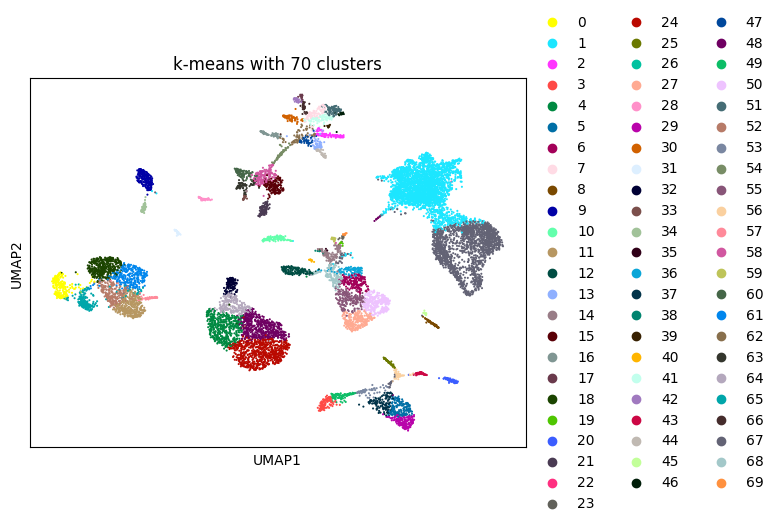

In [21]:
#k-means cluster numbers to try
cluster_numbers = [20, 30, 50, 70]

#original "cluster"
sc.pl.umap(hvg_adata, color=['cluster'], title='Original Clusters')

for n_clusters in cluster_numbers:
    #Apply k-means on the PCA-reduced data
    X_pca = hvg_adata.obsm['X_pca']  # Assuming PCA is already done
    kmeans = KMeans(n_clusters=n_clusters, random_state=5243)
    hvg_adata.obs[f'kmeans_{n_clusters}_clusters'] = kmeans.fit_predict(X_pca).astype(str)

    #Compute UMAP embedding
    if 'X_umap' not in hvg_adata.obsm.keys():
        sc.tl.umap(hvg_adata)

    #UMAP colored by k-means clusters
    sc.pl.umap(hvg_adata, color=[f'kmeans_{n_clusters}_clusters'], title=f'k-means with {n_clusters} clusters')



In [22]:
#Metrics
kmeans_labels_dict = {}

cluster_numbers = [20, 30, 50, 70]

for n_clusters in cluster_numbers:
    #Apply k-means on the PCA-reduced data
    X_pca = hvg_adata.obsm['X_pca']
    kmeans = KMeans(n_clusters=n_clusters, random_state=5243)
    kmeans_labels = kmeans.fit_predict(X_pca)

    #Compute Silhouette Score for k-means
    silhouette_avg = silhouette_score(X_pca, kmeans_labels)

    kmeans_labels_dict[n_clusters] = kmeans_labels

    #Compare k-means with Leiden clustering using ARI
    leiden_labels = hvg_adata.obs['leiden'].astype(int).values  # Assuming Leiden is already computed
    ari_kmeans_vs_leiden = adjusted_rand_score(leiden_labels, kmeans_labels)

    print(f'n_clusters = {n_clusters}: Silhouette Score = {silhouette_avg}, ARI (vs Leiden) = {ari_kmeans_vs_leiden}')

#compare ARI and Rand Index between different k-means clusterings
print("\nARI and Rand Index comparisons between different k-means cluster numbers:")
for i, n1 in enumerate(cluster_numbers):
    for n2 in cluster_numbers[i+1:]:
        #Compare clustering results between two different k-means cluster numbers using Rand Index
        rand_idx = rand_score(kmeans_labels_dict[n1], kmeans_labels_dict[n2])

        #Compute ARI between different k-means clusterings
        ari_between_clusters = adjusted_rand_score(kmeans_labels_dict[n1], kmeans_labels_dict[n2])

        print(f'Rand Index between n_clusters = {n1} and n_clusters = {n2}: {rand_idx}')
        print(f'ARI between n_clusters = {n1} and n_clusters = {n2}: {ari_between_clusters}')


n_clusters = 20: Silhouette Score = 0.5099190473556519, ARI (vs Leiden) = 0.21418256750882678
n_clusters = 30: Silhouette Score = 0.5065547227859497, ARI (vs Leiden) = 0.2239268394750268
n_clusters = 50: Silhouette Score = 0.5120317935943604, ARI (vs Leiden) = 0.23083634454392576
n_clusters = 70: Silhouette Score = 0.3256814777851105, ARI (vs Leiden) = 0.3382090096974829

ARI and Rand Index comparisons between different k-means cluster numbers:
Rand Index between n_clusters = 20 and n_clusters = 30: 0.9808932817502912
ARI between n_clusters = 20 and n_clusters = 30: 0.9352404003121362
Rand Index between n_clusters = 20 and n_clusters = 50: 0.9674686743834265
ARI between n_clusters = 20 and n_clusters = 50: 0.8858119462083444
Rand Index between n_clusters = 20 and n_clusters = 70: 0.8973533712051939
ARI between n_clusters = 20 and n_clusters = 70: 0.5715694388518577
Rand Index between n_clusters = 30 and n_clusters = 50: 0.9820736808632623
ARI between n_clusters = 30 and n_clusters = 50

Genes present in hvg_adata_cleaned: ['wnt5a', 'loc100488523', 'loc100492954', 'egfl6', 'lpar3', 'cpa6', 'sp9', 'fgf9', 'fbn2', 'tinagl1', 'fgf7', 'vwde', 'lef1', 'lamb2', 'fgfr4', 'fgf7', 'rspo2', 'cpa6', 'loc100498358', 'krt', 'loc100486832', 'jag1', 'Xelaev18043128m', 'dlx2', 'tp73', 'gdf6', 'Xelaev18046800m', 'nid2', 'igfbp2', 'ism2', 'dlx2', 'loc100493805', 'frem2', 'Xelaev18044182m', 'bmp5', 'tspear', 'sema3f', 'robo4', 'jchain', 'rspo2', 'adamts18', 'pltp', 'Xelaev18034799m', 'lamb1', 'lamb1', 'unc5b', 'mmp28', 'pzp', 'galnt15']
Genes missing from hvg_adata_cleaned: ['fgf10']


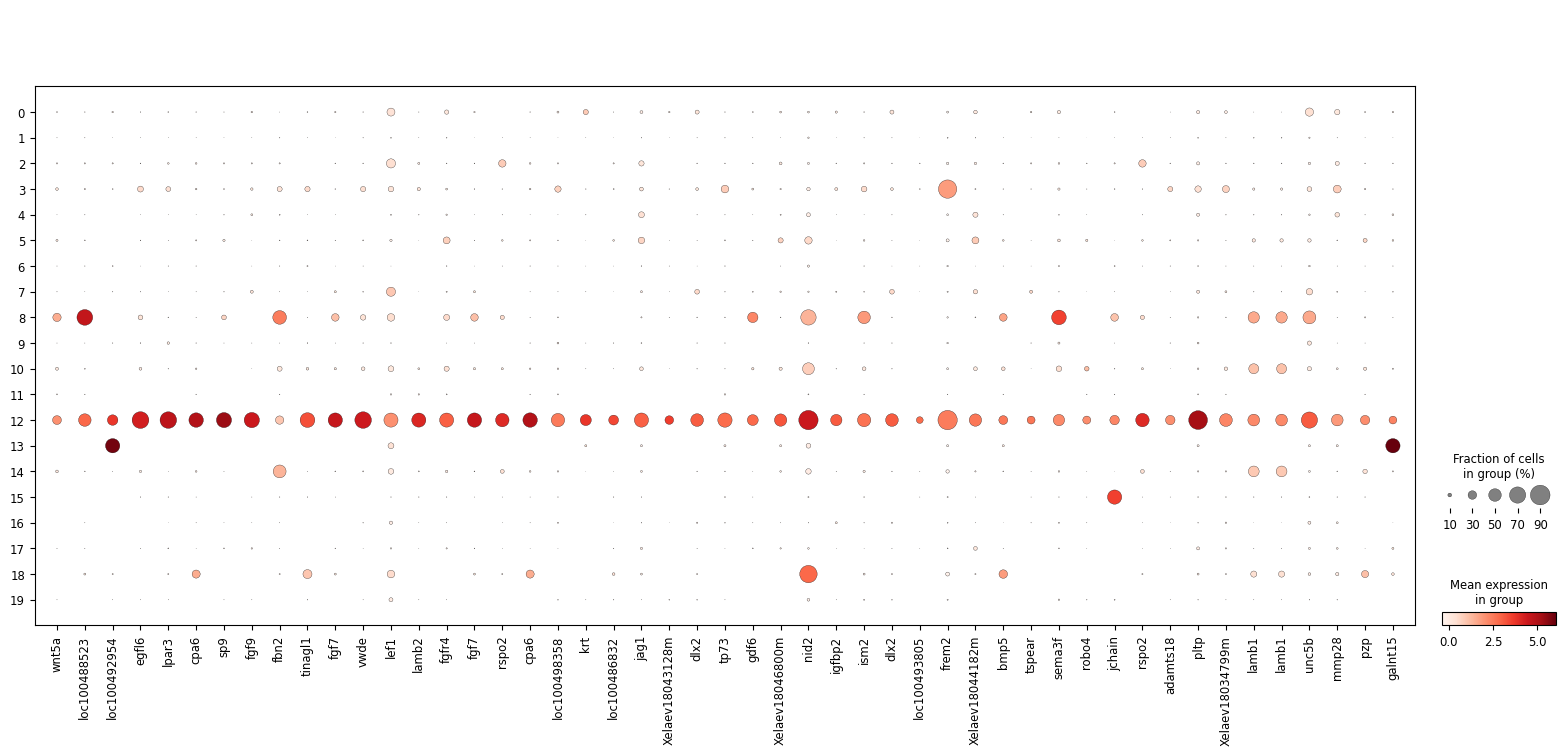

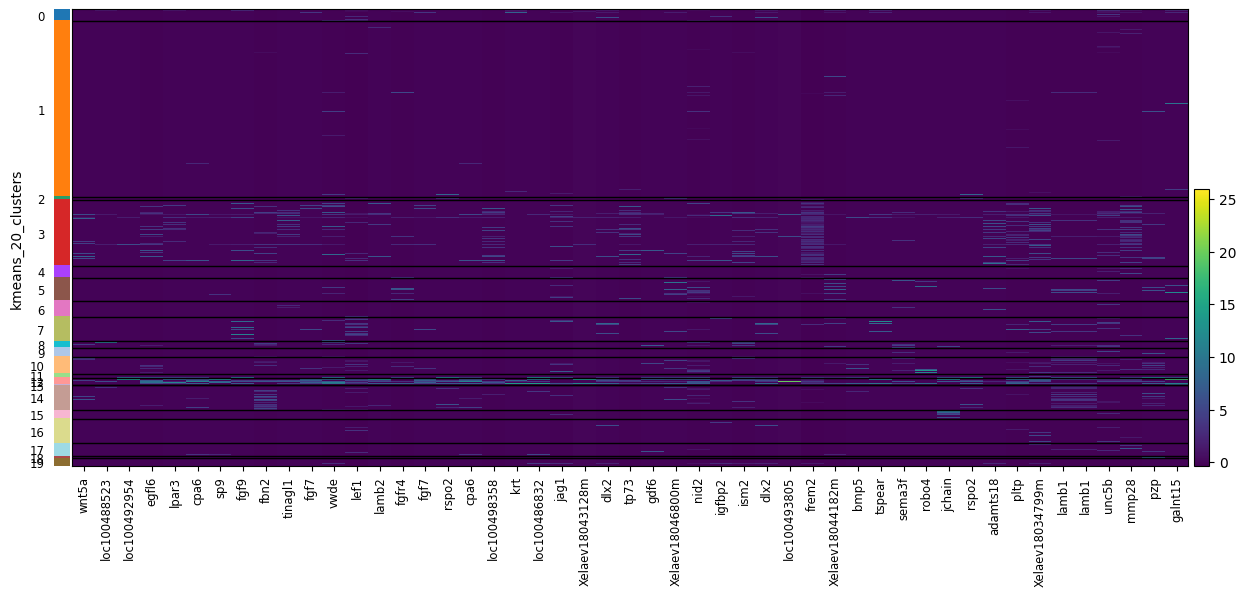

In [23]:
#KMeans 20
hvg_adata_cleaned = hvg_adata.copy()

hvg_adata_cleaned.var_names = [gene.replace('.L', '').replace('.S', '').replace('.g', '') for gene in hvg_adata_cleaned.var_names]

hvg_adata_cleaned.var_names_make_unique()

missing_genes = [gene for gene in given_genes_cleaned if gene not in hvg_adata_cleaned.var_names]

print(f"Genes present in hvg_adata_cleaned: {present_genes}")
print(f"Genes missing from hvg_adata_cleaned: {missing_genes}")

#If there are present genes, create the visualizations; otherwise, print a message
if len(present_genes) > 0:
    #Dot plot to visualize the expression of the present genes across clusters
    sc.pl.dotplot(hvg_adata_cleaned, present_genes, groupby='kmeans_20_clusters')

    #Heatmap to visualize the expression of the present genes across clusters
    sc.pl.heatmap(hvg_adata_cleaned, present_genes, groupby='kmeans_20_clusters')
else:
    print("No genes from the given list are present in hvg_adata_cleaned.")


Selected cluster: 12 with mean expression: 3.2088542417247368


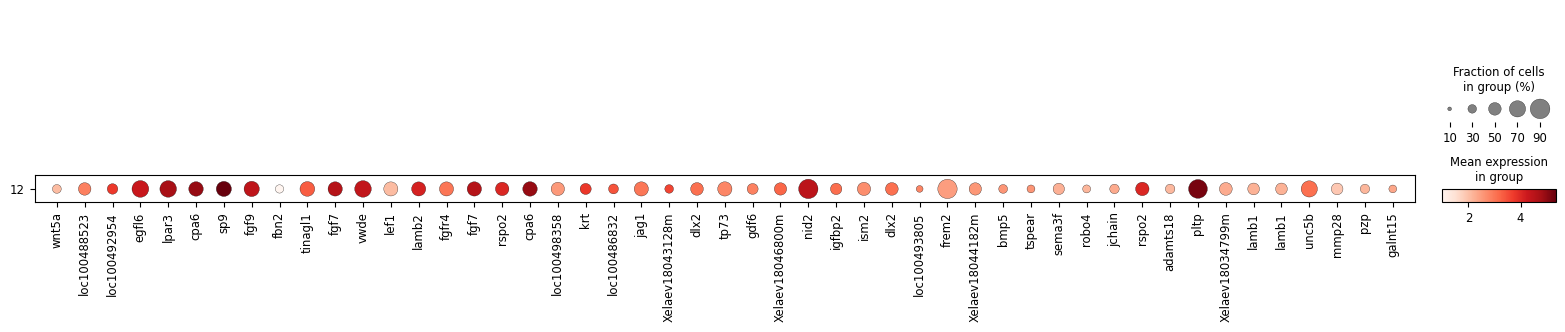

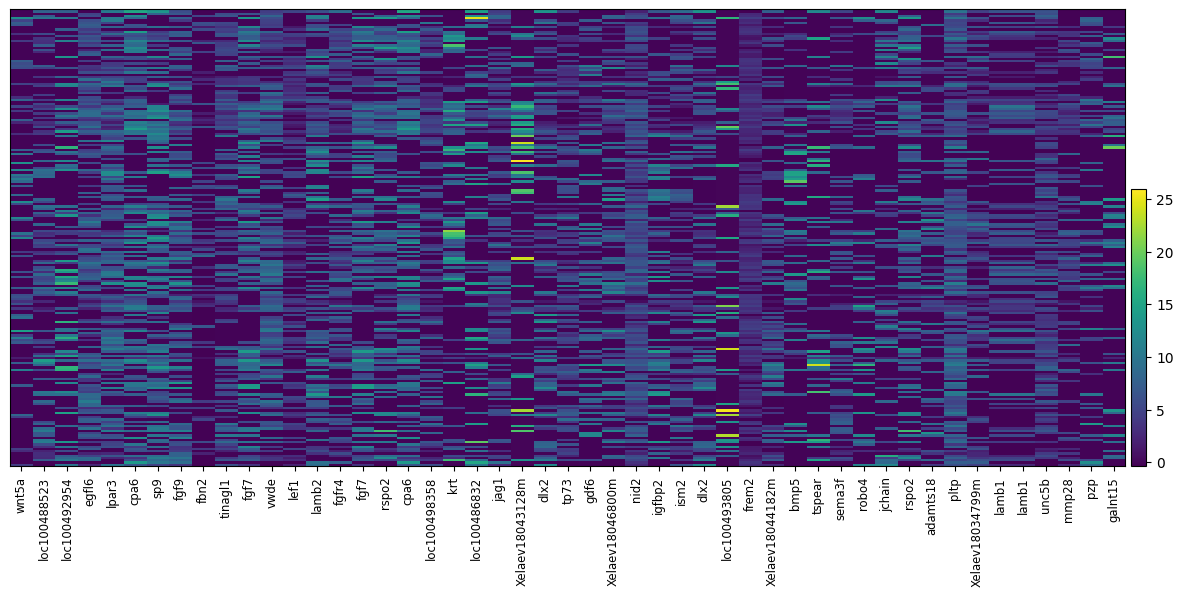

In [24]:
#Select the cluster with the highest mean expression of the present genes
if len(present_genes) > 0:
    selected_cluster = None
    highest_mean_expression = -np.inf

    #Iterate through all clusters and calculate the mean expression of the present genes
    for cluster in hvg_adata_cleaned.obs['kmeans_20_clusters'].unique():

        cluster_data = hvg_adata_cleaned[hvg_adata_cleaned.obs['kmeans_20_clusters'] == cluster]

        #Calculate mean expression for all present genes in this cluster
        gene_expressions = []
        for gene in present_genes:
            gene_expression = cluster_data[:, hvg_adata_cleaned.var_names == gene].X.mean()
            gene_expressions.append(gene_expression)

        mean_expression = np.mean(gene_expressions)

        #Update selected cluster if this one has the highest mean expression
        if mean_expression > highest_mean_expression:
            highest_mean_expression = mean_expression
            selected_cluster = cluster

    #If a cluster is selected, proceed with visualizations
    if selected_cluster:
        print(f"Selected cluster: {selected_cluster} with mean expression: {highest_mean_expression}")

        #Subset data for the selected cluster
        cluster_of_interest_data = hvg_adata_cleaned[hvg_adata_cleaned.obs['kmeans_20_clusters'] == selected_cluster]

        #Visualize using dot plot and heatmap for the selected genes
        sc.pl.dotplot(cluster_of_interest_data, var_names=present_genes, groupby='kmeans_20_clusters')
        sc.pl.heatmap(cluster_of_interest_data, var_names=present_genes, groupby='kmeans_20_clusters')

    else:
        print("No cluster met the selection criteria.")
else:
    print("No genes from the given list are present in hvg_adata_cleaned.")

In [25]:
selected_cluster

'12'

In [26]:
#Marker gene identification using 'wilcoxon' as the method
sc.tl.rank_genes_groups(hvg_adata, 'kmeans_20_clusters', groups=[selected_cluster], method='wilcoxon')

marker_genes = hvg_adata.uns['rank_genes_groups']

#Extract the marker genes for selected cluster
marker_genes_df = pd.DataFrame({
    'genes': marker_genes['names'][selected_cluster],
    'logfoldchanges': marker_genes['logfoldchanges'][selected_cluster],
    'pvals_adj': marker_genes['pvals_adj'][selected_cluster]
})

#Modify the 'genes' column to remove everything after and including '.'
marker_genes_df['genes'] = marker_genes_df['genes'].str.replace(r'\..*', '', regex=True)

#Top 70 marker genes by adjusting for the top genes
top_70_marker_genes = marker_genes_df.head(70)

print(top_70_marker_genes)


           genes  logfoldchanges      pvals_adj
0          apoc1             NaN  1.630139e-120
1        col14a1             NaN  9.058170e-120
2   loc100486548             NaN  4.663117e-118
3          fras1             NaN  1.496362e-111
4          bambi             NaN  1.256826e-109
..           ...             ...            ...
65         mxra5             NaN   1.481428e-54
66         prdm1             NaN   9.565402e-54
67         acvr1             NaN   2.366713e-53
68        ly6g6c             NaN   1.144070e-52
69          gjb3             NaN   1.281288e-52

[70 rows x 3 columns]


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [27]:
common_genes_df = top_70_marker_genes[top_70_marker_genes['genes'].isin(given_genes_list)]

#Remove duplicate gene names
unique_common_genes_df = common_genes_df.drop_duplicates(subset='genes')

print(unique_common_genes_df)
#Show matching genes
print(len(unique_common_genes_df['genes']))


     genes  logfoldchanges      pvals_adj
8    frem2             NaN  4.517958e-101
12    nid2             NaN   1.124606e-94
16    pltp             NaN   2.274767e-89
19   egfl6             NaN   1.666108e-88
34  igfbp2             NaN   8.364211e-70
46   lpar3             NaN   1.757069e-64
49    vwde             NaN   1.179562e-63
60   unc5b             NaN   1.700793e-55
8


In [28]:
len(given_genes_list)

50

In [29]:
full_common_genes_df = marker_genes_df[marker_genes_df['genes'].isin(given_genes_list)]

#Show the full common genes
print(full_common_genes_df)
len(full_common_genes_df)

       genes  logfoldchanges      pvals_adj
8      frem2             NaN  4.517958e-101
12      nid2             NaN   1.124606e-94
16      pltp             NaN   2.274767e-89
19     egfl6             NaN   1.666108e-88
24     frem2             NaN   3.337052e-81
...      ...             ...            ...
784   tspear             NaN   9.989444e-01
830    mmp28             NaN   9.989444e-01
849      sp9             NaN   9.989444e-01
1553   lamb2             NaN   9.989444e-01
3621  sema3f             NaN   9.989444e-01

[66 rows x 3 columns]


66

In [30]:
#Extract the expression data and the cluster labels
X = hvg_adata_cleaned.X  # Gene expression data
y = hvg_adata_cleaned.obs['kmeans_20_clusters'].values  # Cluster labels

#cluster of interest
cluster_of_interest = selected_cluster
y_binary = np.where(y == cluster_of_interest, 1, 0)  # Convert to binary: 1 for cluster 32, 0 for others

#Logistic regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X, y_binary)

#Get importance of the genes from logistic regression
gene_importance = lr.coef_[0]

#Rank genes by their importance
gene_ranking = np.argsort(np.abs(gene_importance))[::-1]

#Get the names of the top 70 marker genes
top_genes = hvg_adata_cleaned.var_names[gene_ranking[:70]]  # Top 60 genes

print("Top 60 marker genes for cluster", cluster_of_interest)
print(top_genes)
len(top_genes)

Top 60 marker genes for cluster 12
Index(['sp9', 'Xetrov90029035m', 'krt', 'lpar3', 'Xelaev18046355m', 'lamb2',
       'loc100486832', 'rspo2-1', 'fgf7', 'loc100492954', 'igfbp2', 'arfip2',
       'vit-1', 'Xelaev18043128m', 'Xelaev18008610m', 'fgf7-1', 'sema3f',
       'dkk1-1', 'Xelaev18034799m', 'Xelaev18035742m', 'tcn2-1',
       'loc101732997', 'Xetrov90028350m', 'cpa6', 'megf6', 'adamts6', 'cpa6-1',
       'olfml2b-1', 'robo4', 'Xelaev18017960m', 'jchain', 'vit', 'c3-1',
       'efemp2', 'pltp', 'dkk1', 'mxra5-1', 'mmp3', 'Xelaev18032050m',
       'Xelaev18034615m', 'sds-1', 'Xelaev18040375m', 'robo4-1',
       'Xetrov90004185m', 'krt8', 'Xelaev18043129m', 'Xelaev18034617m',
       'Xelaev18014807m', 'tspear-1', 'loc100490379', 'col27a1-1', 'duoxa1-1',
       'dlx5', 'fras1', 'rspo2', 'Xelaev18020525m', 'kazald1', 'hmcn1',
       'loc100493805', 'ngf', 'acp5', 'loc100498388', 'bmp5', 'cxcl14',
       'fabp3-1', 'slc13a3', 'apoc1.like', 'efemp1', 'dll1', 'fgfbp1'],
      dtype='ob

70

In [31]:
#Clean the gene names by removing '-1' suffix from the top marker genes
top_genes_cleaned = [gene.replace('-1', '') for gene in top_genes]

#Compare the cleaned top 70 marker genes to the reference list

given_genes_set = set(given_genes_list)

top_genes_cleaned_set = set(top_genes_cleaned)

common_genes = top_genes_cleaned_set.intersection(given_genes_set)

#Common genes between the cleaned top 70 marker genes and the reference list
print(common_genes)
len(common_genes)

{'igfbp2', 'pltp', 'Xelaev18043128m', 'jchain', 'robo4', 'loc100486832', 'loc100493805', 'lamb2', 'sp9', 'tspear', 'fgf7', 'loc100492954', 'Xelaev18034799m', 'cpa6', 'lpar3', 'bmp5', 'rspo2', 'sema3f', 'krt'}


19

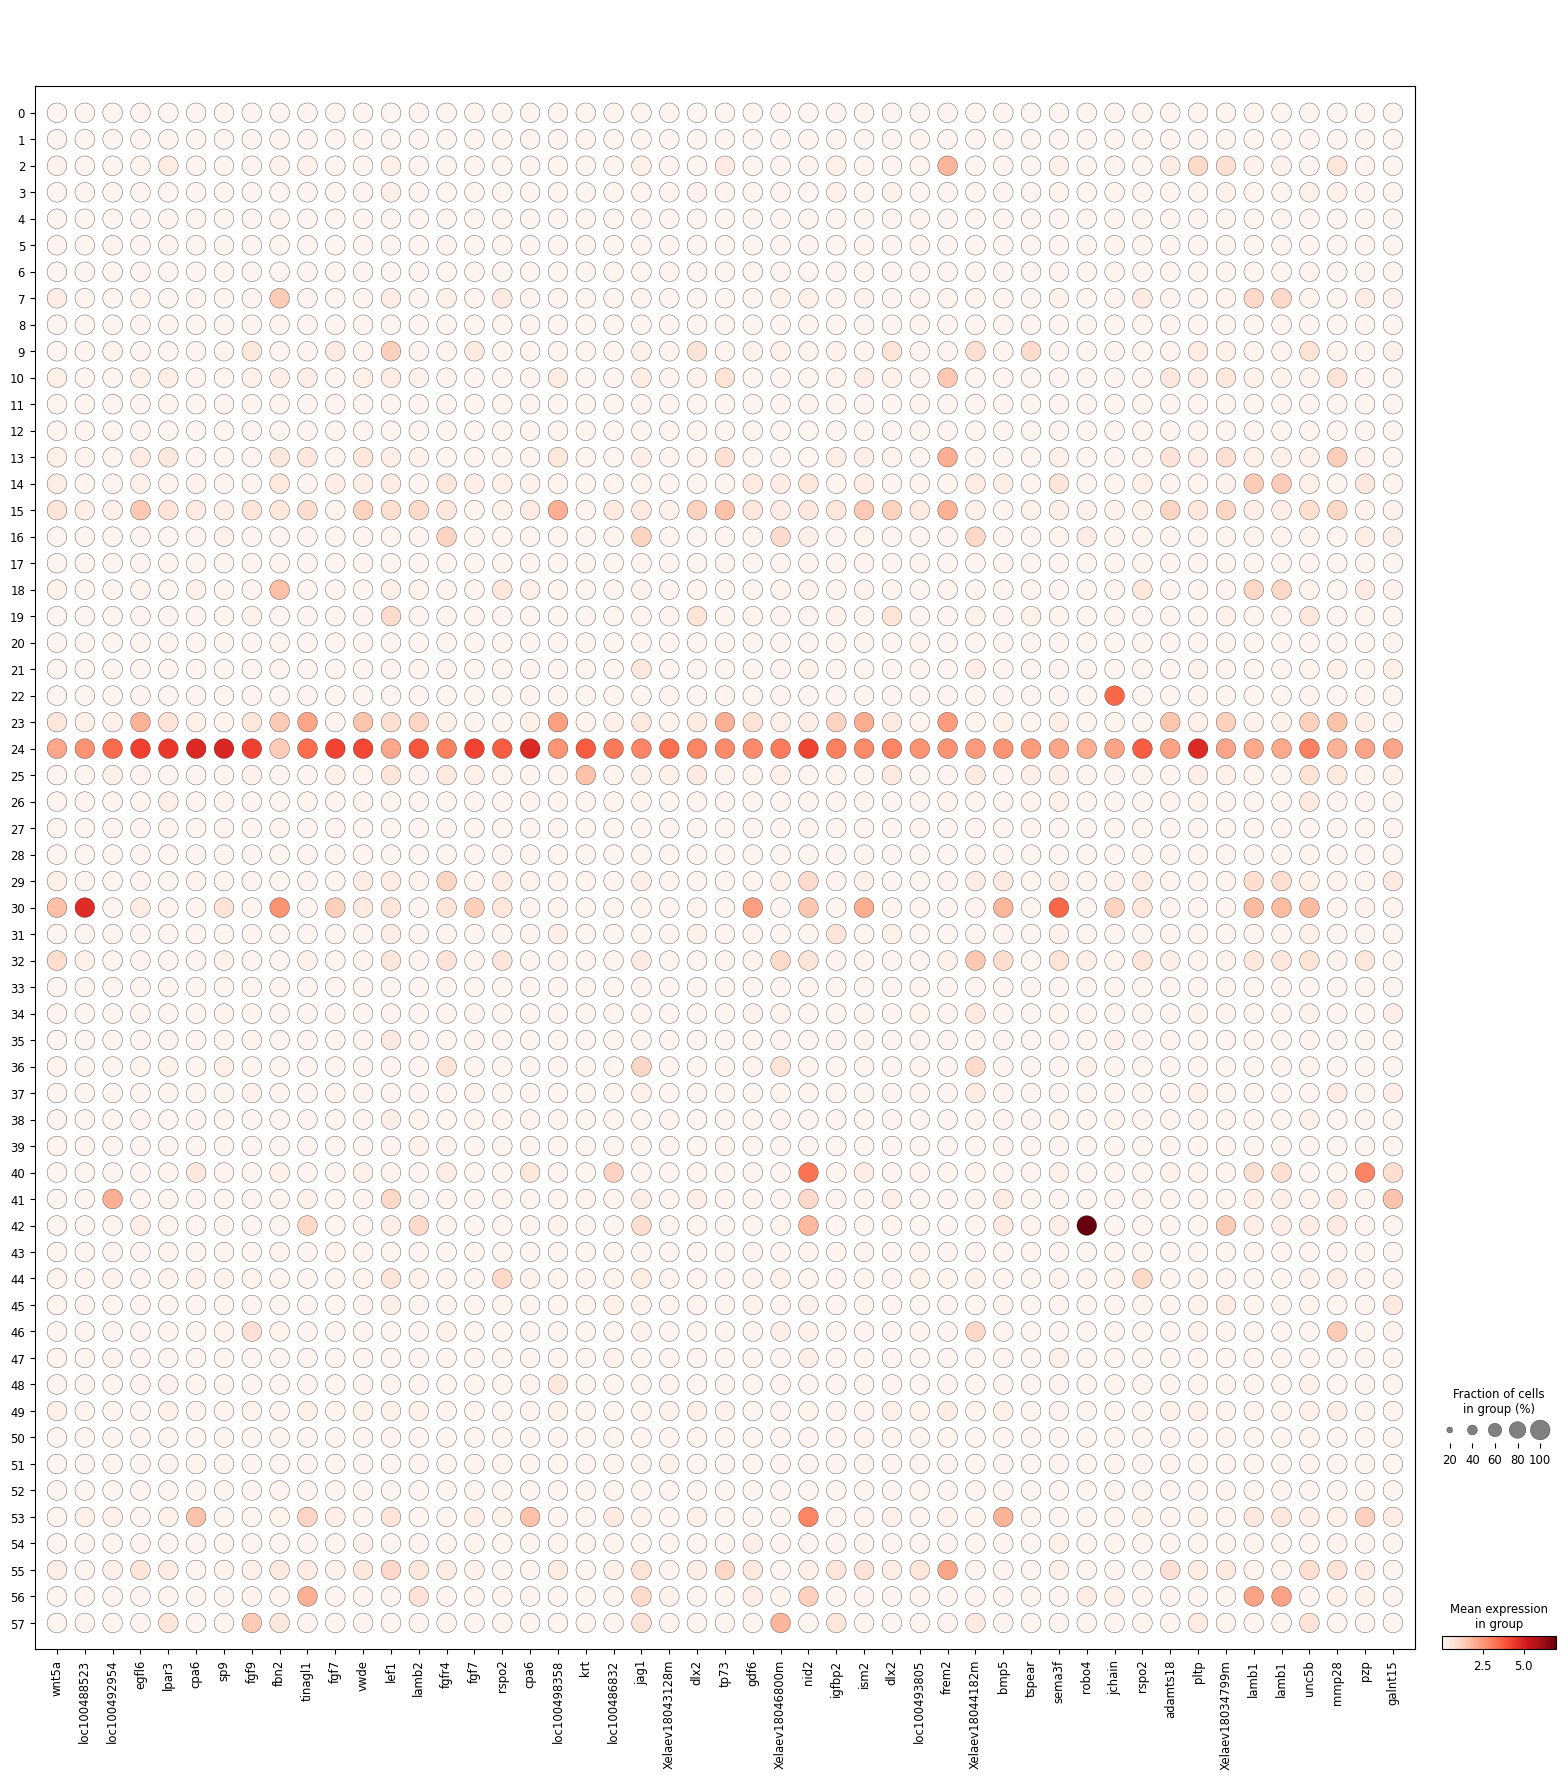

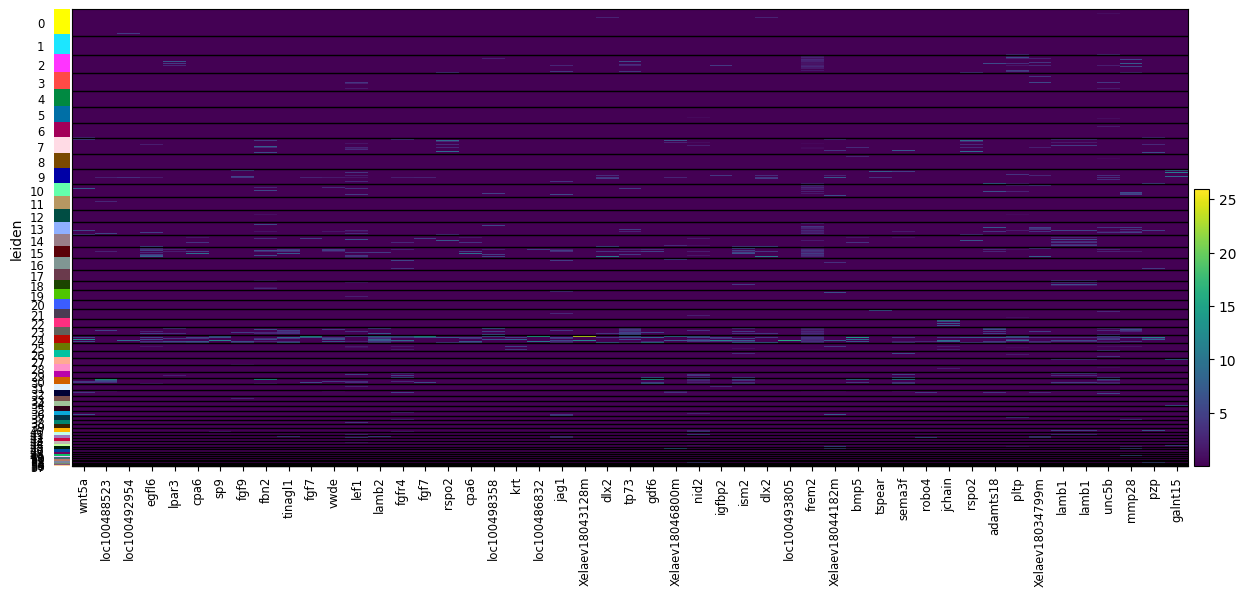

In [32]:
#Perform KNN and Leiden clustering
sc.pp.neighbors(hvg_adata_cleaned, n_neighbors=35, use_rep='X_pca')  # Adjust n_neighbors as needed
sc.tl.leiden(hvg_adata_cleaned, resolution=3.0)  # Adjust resolution as needed for cluster granularity

#Fix invalid values (zero or negative) in the data to avoid issues with log2
#Add small value to avoid log(0) or negative log-fold changes
hvg_adata_cleaned.X = np.where(hvg_adata_cleaned.X <= 0, 1e-6, hvg_adata_cleaned.X)

#Identify marker genes for each Leiden cluster using the Wilcoxon rank method
sc.tl.rank_genes_groups(hvg_adata_cleaned, groupby='leiden', method='wilcoxon')


#Visualize the marker gene expression using dot plot and heatmap
if len(present_genes) > 0:
    #Dot plot to visualize the expression of the present genes across Leiden clusters
    sc.pl.dotplot(hvg_adata_cleaned, present_genes, groupby='leiden')

    #Heatmap to visualize the expression of the present genes across Leiden clusters
    sc.pl.heatmap(hvg_adata_cleaned, present_genes, groupby='leiden')

else:
    print("No genes from the given list are present in hvg_adata_cleaned.")

Selected cluster: 24 with mean expression: 3.093940482220838


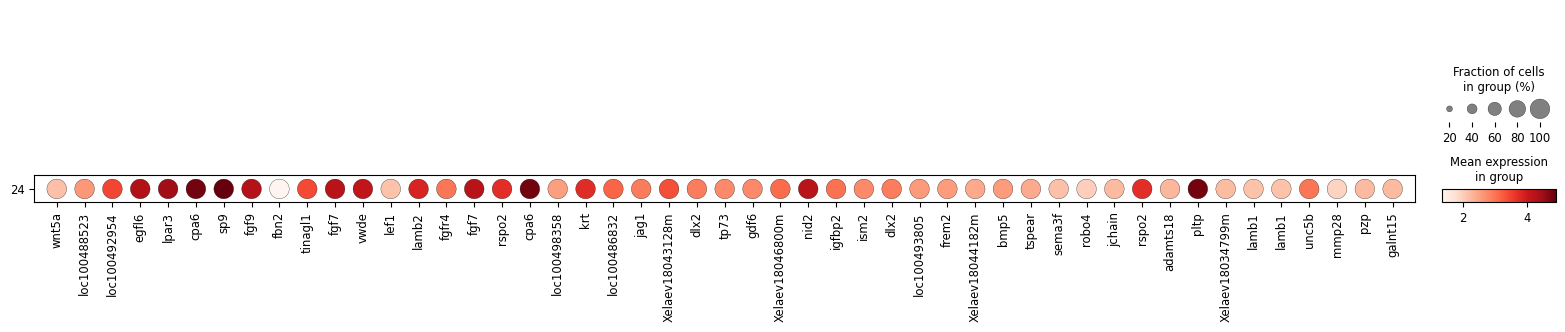

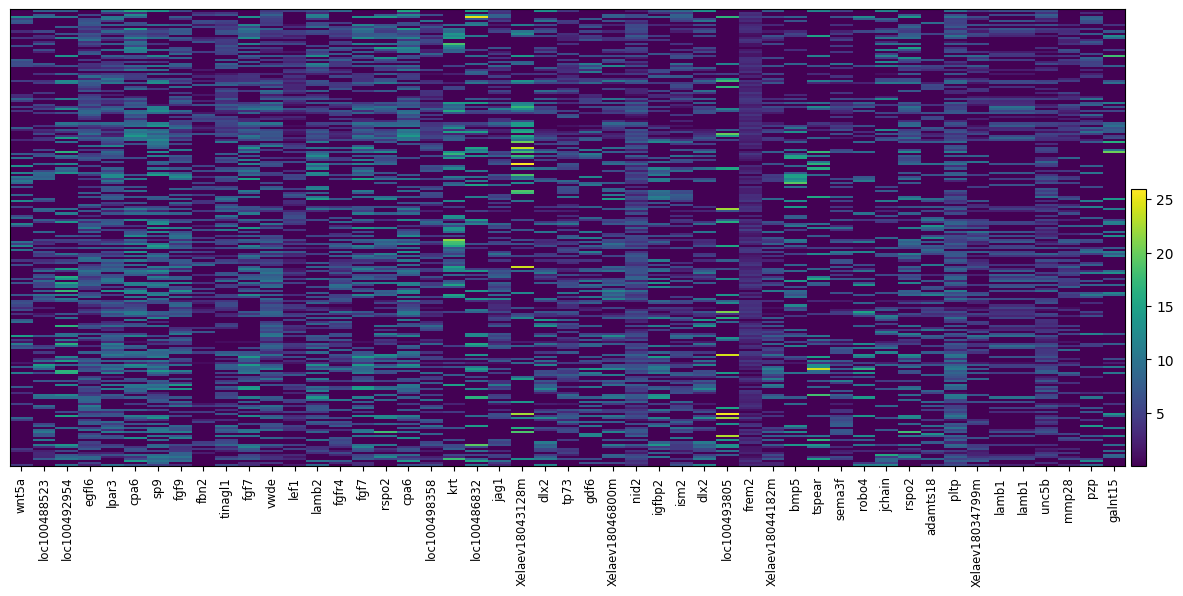

In [33]:
#Initialize variables for cluster selection
selected_cluster = None
highest_mean_expression = -np.inf

#Iterate through all Leiden clusters and calculate the mean expression of the present genes
for cluster in hvg_adata_cleaned.obs['leiden'].unique():
    #Subset the data for this cluster
    cluster_data = hvg_adata_cleaned[hvg_adata_cleaned.obs['leiden'] == cluster]

    #Calculate mean expression for all present genes in this cluster
    gene_expressions = []
    for gene in present_genes:
        gene_expression = cluster_data[:, hvg_adata_cleaned.var_names == gene].X.mean()
        gene_expressions.append(gene_expression)

    #Calculate the mean expression across all present genes
    mean_expression = np.mean(gene_expressions)

    #Update selected cluster if this one has the highest mean expression
    if mean_expression > highest_mean_expression:
        highest_mean_expression = mean_expression
        selected_cluster = cluster

#If cluster is selected, proceed with visualizations
if selected_cluster:
    print(f"Selected cluster: {selected_cluster} with mean expression: {highest_mean_expression}")

    #Subset data for the selected cluster
    cluster_of_interest_data = hvg_adata_cleaned[hvg_adata_cleaned.obs['leiden'] == selected_cluster]

    #Visualize using dot plot and heatmap for the selected genes
    sc.pl.dotplot(cluster_of_interest_data, var_names=present_genes, groupby='leiden')
    sc.pl.heatmap(cluster_of_interest_data, var_names=present_genes, groupby='leiden')

else:
    print("No cluster met the selection criteria.")


In [34]:
#Number of top genes to select
top_n = 70
hvg_adata_cleaned.X = hvg_adata_cleaned.X + 1e-6
#Perform Wilcoxon rank-sum test for identifying marker genes
sc.tl.rank_genes_groups(hvg_adata_cleaned, groupby='leiden', method='wilcoxon')

#Extract the top N marker genes for the selected cluster
selected_genes_wilcoxon = pd.DataFrame(hvg_adata_cleaned.uns['rank_genes_groups']['names'])[selected_cluster].head(top_n)

#Overlap of genes between the top N genes
overlapping_genes = list(set(given_genes_cleaned).intersection(set(selected_genes_wilcoxon)))

print(f"Overlapping genes: {overlapping_genes}")
print(f"Number of overlapping genes: {len(overlapping_genes)}")


Overlapping genes: ['unc5b', 'frem2', 'vwde', 'pltp', 'nid2', 'egfl6', 'lpar3']
Number of overlapping genes: 7


In [35]:
#Logistic regression for identifying marker genes
sc.tl.rank_genes_groups(hvg_adata_cleaned, groupby='leiden', method='logreg', max_iter=1000)  # Increase max_iter as needed

#Extract the top N marker genes for the selected cluster
top_n = 70
selected_genes_logreg = pd.DataFrame(hvg_adata_cleaned.uns['rank_genes_groups']['names'])[selected_cluster].head(top_n)

overlapping_genes = list(set(given_genes_cleaned).intersection(set(selected_genes_logreg)))

#Output the overlapping gene names and the size of the overlap
print(f"Overlapping genes (Logistic Regression): {overlapping_genes}")
print(f"Number of overlapping genes (Logistic Regression): {len(overlapping_genes)}")


Overlapping genes (Logistic Regression): ['unc5b', 'dlx2', 'fgf9', 'igfbp2', 'vwde', 'gdf6', 'ism2', 'jchain', 'tinagl1', 'tp73', 'fgfr4', 'lamb2', 'sp9', 'fgf7', 'pzp', 'jag1', 'fbn2', 'adamts18', 'nid2', 'egfl6', 'cpa6', 'bmp5', 'loc100498358', 'sema3f', 'krt']
Number of overlapping genes (Logistic Regression): 25
